# Rainy days on the stock market

Dataproject by Josefine Pedersen, Viktor Texel and Pernille Svendsen

> **Table of contents** 
> - Introduction
> - Read and clean data from DMI and Yahoo Finance
> - Exploring the datasets
> - Merging the datasets
> - Analysis
> - Conclusion

*Imports and set magics:*

In [1]:
# Import tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import requests # library for making HTTP requests
import datetime as dt # library for handling date and time objects
from PIL import Image
from scipy.stats import pearsonr
from skimage import io

# Autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# User written modules
import dataproject as dp

*Installation and import of data-specific tools and packages:*

**Note**: If the packages for importing data has not been installed, un-comment and run.

In [2]:
# We install a package to inspect data from DMI (The Danish Meteorological Institute):
#%pip install dmi-open-data

# We install nescesarry packages from Yahoo Finance
#%pip install yfinance
#%pip install yahoofinancials

import yfinance as yf
from yahoofinancials import YahooFinancials

# Introduction

In this dataproject we wish to explore if there could be a correlation between weather and developments on the stock market. Through API's we import datasets from DMI and Yahoo Finance to examine whether or not there is a correlation between price fluctuations in the danish OMX C25-index and the amount of precipitation in Denmark. 

To do so, we carefully select comparable data from our datasets, clean it and analyze it using different python-tools. We find that there is litte-to-no correlation between precipitation and fluctuations in the share price of OMX C25 in Denmark.  

# Read and clean data from DMI and Yahoo Finance

In this section we import our data through API's and load it. To do so, the packages *dmi-open data*, *yfinance* and *yfinancials* needs to be installed. These are included at the top in our *import and set magics* section and can be installed by removing the '#' and then running the code. 

**We import data from DMI and print the available parameters**:

In [3]:
# We use an API-key given to us from DMI's database to retrieve data
api_key = 'bd463c7d-f6f8-431d-a5a7-c466766a8363'
DMI_URL = 'https://dmigw.govcloud.dk/v2/metObs/collections/observation/items'

dp.import_data_dmi(api_key,DMI_URL)

array(['temp_dew', 'humidity', 'cloud_cover', 'temp_max_past12h',
       'pressure_at_sea', 'wind_speed', 'temp_soil_max_past1h', 'weather',
       'wind_dir', 'temp_dry', 'precip_dur_past10min', 'temp_grass',
       'leav_hum_dur_past10min', 'temp_min_past1h', 'precip_past1min',
       'precip_past1h', 'pressure', 'radia_glob', 'wind_speed_past1h',
       'humidity_past1h', 'sun_last10min_glob', 'precip_past10min',
       'visib_mean_last10min', 'leav_hum_dur_past1h', 'visibility',
       'temp_soil', 'temp_soil_min_past1h', 'wind_min',
       'temp_grass_min_past1h', 'wind_min_past1h', 'cloud_height',
       'temp_min_past12h', 'wind_max_per10min_past1h', 'temp_max_past1h',
       'temp_soil_mean_past1h', 'wind_max', 'wind_dir_past1h',
       'precip_dur_past1h', 'temp_grass_mean_past1h',
       'wind_gust_always_past1h', 'sun_last1h_glob', 'temp_mean_past1h',
       'radia_glob_past1h', 'temp_grass_max_past1h', 'snow_depth_man'],
      dtype=object)

From the parameters above, we select the parameter *precip_past1h* which returns the amount of precipitation the last hour in kg/m2 for a given period.

As we have now picked the necessary parameter for our analysis, we have to specify what timeperiod we wanna look at, which DMI-weather stations is relevant to include, and how to structure our DMI-dataset.

We wanna look at the most recent full year, 2022. We specify our timeperiod to start at the first hour of the first day of 2022, and end at the first hour of the first day of 2023 - this is needed to have the entire period of 2022, but the observation from 2023 will be discarded. 

DMI has a lot of weatherstations scattered across Denmark, The Faroe Islands and Greenland. These weather stations have different capabilities, and some measure the same as others - meaning there is a risk of having measurements for a given geographical location twice. We only wanna look at *Pluvio* stations in Denmark, as these measure precipitation, cover the entirety of Denmark and are unique (only one station pr. location). Therefore we sort our data to only include *Pluvio* station IDs. 

The *Pluvio* stations are located as depicted below:

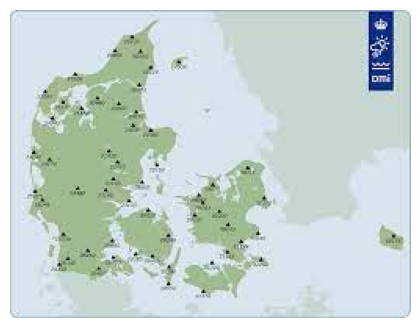

In [4]:
# Load the image
image = io.imread('Pluvio.png')

# Create a figure and plot the image
fig, ax = plt.subplots(figsize=(6, 4), dpi=100)
ax.imshow(image)
ax.axis('off')
plt.show()

We select the data we need for our analysis and create the dataframe. **Note** that this takes **a couple of minutes**, since the API is set up such that we need to import the data from one station at a time.

In [5]:
# Specifying the relevant parameter for the analysis
parameterId = ['precip_past1h']

# Creating the dataframe
df = dp.selecting_data_dmi(parameterId)
df.head()

station,Time,05005,05009,05015,05031,05035,05042,05065,05070,05075,...,05545,05575,05735,05880,05889,05935,05945,05970,05986,05994
0,2022-01-01 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.00,0.0
1,2022-01-01 01:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.08,0.0
2,2022-01-01 02:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.00,0.0
3,2022-01-01 03:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.00,0.0
4,2022-01-01 04:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0.0,0.0,0.0,NaN,NaN,0.0,0.00,0.0


To simplify the data we calculate the average of precipitation across all selected *pluvio* weather stations and store this data.

In [6]:
# We create a row-average of the observations across weather stations
df['Precip'] = df.mean(axis=1, numeric_only = True)
df['Date'] = df.Time.dt.date 
df2 = df[['Time', 'Date', 'Precip']] 
df2

station,Time,Date,Precip
0,2022-01-01 00:00:00+00:00,2022-01-01,0.008364
1,2022-01-01 01:00:00+00:00,2022-01-01,0.034727
2,2022-01-01 02:00:00+00:00,2022-01-01,0.041296
3,2022-01-01 03:00:00+00:00,2022-01-01,0.015185
4,2022-01-01 04:00:00+00:00,2022-01-01,0.029630
...,...,...,...
8733,2022-12-31 19:00:00+00:00,2022-12-31,0.120656
8734,2022-12-31 20:00:00+00:00,2022-12-31,0.420820
8735,2022-12-31 21:00:00+00:00,2022-12-31,0.611967
8736,2022-12-31 22:00:00+00:00,2022-12-31,0.993770


With 8760 hours in a year we have 22 missing hours. We investigate which days causes the issue.

In [7]:
# We check to see which days have missing hours
check = df2.groupby(['Date'])['Time'].count()
check = pd.DataFrame(check)
check = check.loc[check['Time']!=24]
check

,Time
Date,
2022-06-14,23
2022-06-15,21
2022-06-16,22
2022-06-17,22
2022-06-18,22
2022-06-19,19
2022-06-20,22
2022-06-21,21
2022-06-22,22


From the above table we can see, that for some days in June there is not data from all hours of the day. To tackle this issue, and to make our precipitation data more easily comparable, we calculate the daily average of the precipitation across weather stations (stored as df2) and store this data as df3. Now we have a dataset that displays the average daily precipitation across Denmark. 

In [8]:
df3 = df2.groupby('Date').mean(numeric_only=True)
df3.reset_index(inplace=True)
df3['Date'] =pd.to_datetime(df3['Date'])
df3

station,Date,Precip
0,2022-01-01,0.170616
1,2022-01-02,0.186448
2,2022-01-03,0.158633
3,2022-01-04,0.106235
4,2022-01-05,0.121349
...,...,...
360,2022-12-27,0.099927
361,2022-12-28,0.568777
362,2022-12-29,0.214848
363,2022-12-30,0.117192


**We import and clean data from Yahoo Finance**

In [9]:
# Setting the desired timeframe
from_time='2022-01-01'
to_time='2023-01-01'

# Importing dateframe
OMXC25 = dp.import_data_yahoo(from_time,to_time)
OMXC25

,Date,Close
0,2022-01-03,1970.949951
1,2022-01-04,1952.810059
2,2022-01-05,1947.630005
3,2022-01-07,1867.989990
4,2022-01-10,1825.510010
...,...,...
245,2022-12-23,1695.199951
246,2022-12-27,1701.630005
247,2022-12-28,1695.209961
248,2022-12-29,1712.839966


As can be seen from the table above, there are 250 observations/days where a closing price of OMX 25 have been noted by Yahoo Finance. This is due to the fact that a closing price only occurs when the market is open. There are 260 weekdays in a year, and the 10 "missing" days are holidays.  

## Exploring each data set

Illustrating the average precipitation in 2022 and the closing price of OMXC25 in 2022:

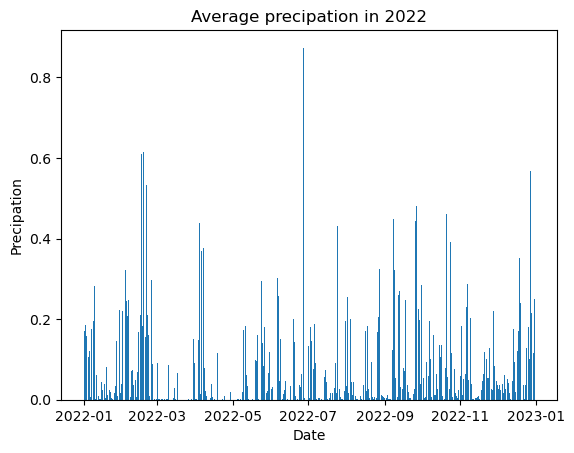

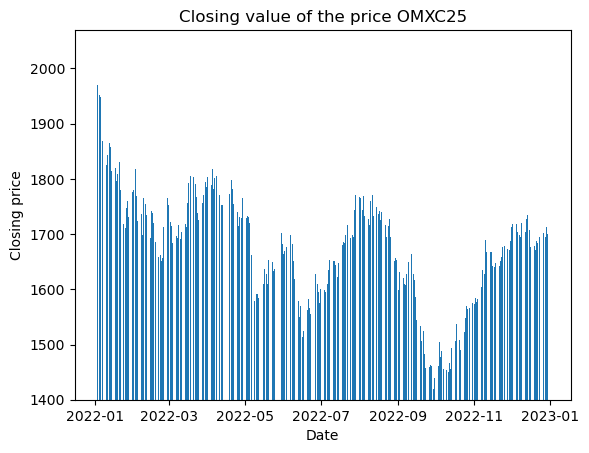

In [10]:
dp.explore_data(df3['Date'],
               df3['Precip'],
               'Average precipation in 2022',
               'Date','Precipation',0);

dp.explore_data(OMXC25['Date'],
               OMXC25['Close'],
               'Closing value of the price OMXC25',
               'Date','Closing price',1400);

Overall we can see that there are large fluctuations in both the average percipation and the closing price of OMXC25, however the fluctuations do not seem to be extremely correlated. To investigate further whether there is a correlation between the two, we merge the dataframes and analyze the data.

# Merge data sets

We combine our loaded data sets from DMI and Yahoo Finance.

In [11]:
# Merge data
precip_stock = pd.merge(OMXC25, df3, on='Date', how='left')
precip_stock2 = precip_stock[['Date', 'Close', 'Precip']]
precip_stock2


,Date,Close,Precip
0,2022-01-03,1970.949951,0.158633
1,2022-01-04,1952.810059,0.106235
2,2022-01-05,1947.630005,0.121349
3,2022-01-07,1867.989990,0.174461
4,2022-01-10,1825.510010,0.002900
...,...,...,...
245,2022-12-23,1695.199951,0.002511
246,2022-12-27,1701.630005,0.099927
247,2022-12-28,1695.209961,0.568777
248,2022-12-29,1712.839966,0.214848


We here use the left-join method to only keep dates where there have been registered a closing price for the stock. Therefore we want to drop all the values for average precipation on weekends and holidays. This is accomplished with this method for merging.

# Analysis

As we are mostly interested in the relative development in the stock price rather than the actual price, we calculate the pct. change from day-to-day to illustrate daily fluctuations. 

In [12]:
# We calculate the pct. change from day-to-day on the closing price of OMXC25
precip_stock2['Change_in_stock'] = ((precip_stock2['Close'] / precip_stock2['Close'].shift(1) - 1)* 100)
precip_stock2.head()

,Date,Close,Precip,Change_in_stock
0,2022-01-03,1970.949951,0.158633,NaN
1,2022-01-04,1952.810059,0.106235,-0.920363
2,2022-01-05,1947.630005,0.121349,-0.265262
3,2022-01-07,1867.989990,0.174461,-4.089073
4,2022-01-10,1825.510010,0.002900,-2.274101


We explore the merged data set to compare within the different months if we can se a correlation. This we do by firstly creating a variable for what month the observation belongs to, and then we plot interactively to study the months individually.

In [13]:
precip_stock3 = precip_stock2.copy()
precip_stock3['Month'] = precip_stock3.Date.dt.month 

In [14]:
# Making an interactive figure
def interactive_figure(Date, Month, Change_in_stock, Precip):
    
    filtered_data = precip_stock3[precip_stock3['Month']==Month]

    fig = plt.figure(figsize=(10,4))

    ax_left = fig.add_subplot(1,2,1)
    ax_left.set_title('Precipitation')
    ax_left.grid(True)
    ax_left.bar(filtered_data['Date'],filtered_data['Precip'])
    ax_left.set_xlabel('Date')
    ax_left.set_ylabel('mm')
    xticks = ax_left.get_xticks()
    ax_left.set_xticks(xticks[::len(xticks) // 4]) # set new tick positions
    ax_left.tick_params(axis='x', rotation=30) # set tick rotation

    ax_right = fig.add_subplot(1,2,2)
    ax_right.set_title('OMXC25')
    ax_right.grid(True)
    ax_right.bar(filtered_data['Date'],filtered_data['Change_in_stock'])
    ax_right.set_xlabel('Date')
    ax_right.set_ylabel('Share price')
    xticks2 = ax_right.get_xticks()
    ax_right.set_xticks(xticks2[::len(xticks2) // 4]) # set new tick positions
    ax_right.tick_params(axis='x', rotation=30) # set tick rotation

    plt.show()

widgets.interact(interactive_figure,
    Date=widgets.fixed(precip_stock3['Date']),
    Month=widgets.Dropdown(description="Month", options=precip_stock3.Month.unique(), value=1),
    Change_in_stock=widgets.fixed(precip_stock3['Change_in_stock']),
    Precip=widgets.fixed(precip_stock3['Precip'])
);

interactive(children=(Dropdown(description='Month', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12), value=1),…

The interactive plots makes it possible to zoom in on one specific month and see how the share price of OMX C25 and the amount of precipitation differs from day to day in each month. 

However, when investigating the months we still don't see a strong correlation between precipation and changes in the stock prices.

As a way to more specifically see if there is a connection between the two variables, we wanna look at the days where the stock price fell/rose the most. Therefore, we utilize python to pick out the 10 days which saw the highest pct. change aswell as the 10 days with the biggest decrease. Our hypothesis is, that the amount of rainfall will be low, when the pct. change in stock is high and vice versa. 

We wanna compare whether the days with the largest increase in stock prices are coinciding with days where there was more rain than usual. Therefore we calculate the average precipation in 2022.

In [15]:
# Calculate average precipation
precip_stock3['Average precip'] = precip_stock3['Precip'].mean(numeric_only=True)

# Calculate deviation from average
precip_stock3['Precip - average'] = (precip_stock3['Precip'] - precip_stock3['Average precip'])

# 10 days with the largest increase in stock price
highest = precip_stock2.nlargest(10,'Change_in_stock') 

# 10 days with the largest decrease in stock price 
lowest = precip_stock2.nsmallest(10, 'Change_in_stock')

We investigate whether days with high increases in the stock price coincide with days with lower than average rain:

In [16]:
highest

,Date,Close,Precip,Change_in_stock
116,2022-06-27,1627.569946,0.873732,4.669573
98,2022-05-30,1702.550049,0.066899,4.050041
26,2022-02-09,1765.050049,0.074717,3.896146
214,2022-11-10,1689.650024,0.039105,3.818742
38,2022-02-25,1713.150024,0.089489,3.369937
39,2022-02-28,1764.810059,0.001019,3.015500
139,2022-07-28,1743.479980,0.001817,2.912998
30,2022-02-15,1742.140015,0.210196,2.910443
187,2022-10-04,1503.920044,0.006535,2.907426
94,2022-05-20,1653.959961,0.095344,2.789811


We see that 6 of the 10 observations have below average precipation, so it does somewhat support the hypothesis, but not to a large degree.

We do the same for the 10 days with largest decrease in the stock price:

In [17]:
lowest

,Date,Close,Precip,Change_in_stock
86,2022-05-09,1579.150024,0.018073,-5.015248
3,2022-01-07,1867.989990,0.174461,-4.089073
110,2022-06-16,1514.329956,0.000181,-3.490537
14,2022-01-24,1719.089966,0.002116,-3.450661
85,2022-05-06,1662.530029,0.001922,-3.391830
164,2022-09-01,1598.030029,0.003558,-3.304995
184,2022-09-29,1419.339966,0.197864,-2.873409
13,2022-01-21,1780.530029,0.023261,-2.766502
22,2022-02-03,1768.459961,0.322891,-2.760278
179,2022-09-22,1483.270020,0.003168,-2.651494


Here we see that only 3 out of 10 oberservations have above average precipation when there is a large fall in the stock price. So overall we do not see a large correlation between precipation and changes in the stock price.

Since there is not really any conclusive evidence in the above analysis, we now want to check if there is a correlation between the share price of the OMXC25 and the precipitation in 2022 for the entire dataframe. 

In [18]:
# Drop the first row (no value for change in stock)
precip_stock4 = precip_stock2.iloc[1:]

# Calculate the correlation
dp.correlation(precip_stock4)

Correlation coefficient: 0.05
p-value: 0.46


The coefficient shows a very weak positive correlation between the precipitation level and the changes in the OMXC25-index. Furthermore, the p-value shows that the correlation is not significant on a 5 pct. confidence level.

We can also see the weak correlation by plotting the observations:

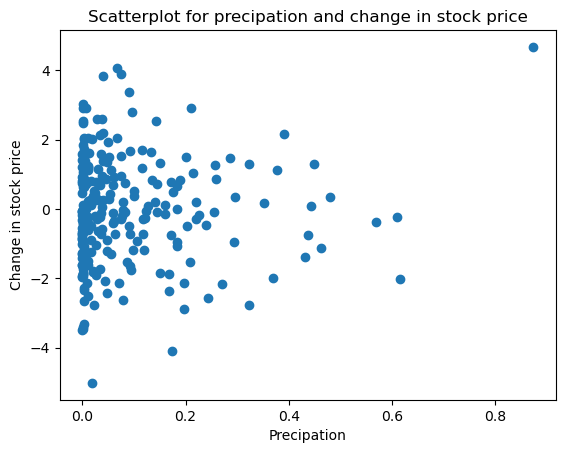

In [19]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.scatter(precip_stock4['Precip'],precip_stock4['Change_in_stock'])

ax.set_title('Scatterplot for precipation and change in stock price')
ax.set_xlabel('Precipation')
ax.set_ylabel('Change in stock price');

Overall the scatterplot above exhibits a very low correlation between the two variables.

# Conclusion

In this assignment we look at the precipitation level in Denmark in 2022 along with the OMXC25 index. We found that there was slim to no correlation between the variables meaning that the weather most likely does not affect the changes in share prices of the OMXC25. 

We come to this conclusion by using descriptive statistics and simple calculations. To investigate a possible correlation between stock prices and the weather satisfactionary, you would have to use much broader methods. The topic have already been analyzed by other economists, who take a look at the stock exchange in New York City. We refer to:

*Goetzmann, William N., and Ning Zhu. "Rain or shine: where is the weather effect?." European Financial Management 11.5 (2005): 559-578.*

*Saunders, Edward M. "Stock prices and Wall Street weather." The American Economic Review 83.5 (1993): 1337-1345.*

The first source states that there is low correlation between weather and stock prices, but the second source states that there to some degree is a correlation between the two. Overall, the conclusion regarding the subject is therefore somewhat ambigous. Our analysis, regarding Danish data, shows now correlation between rain and stock prices.